###Automating Port Operations

Marina Pier Inc. is leveraging technology to automate their operations on the San Francisco
port.

The company’s management has set out to build a bias-free/ corruption-free automatic system
that reports & avoids faulty situations caused by human error. Examples of human error
include misclassifying the correct type of boat. The type of boat that enters the port region is
as follows,

* Buoy
* Cruise_ship
* Ferry_boat
* Freight_boar
* Gondola
* Inflatable_boat
* Kayak
* Paper_boat
* Sailboat

Marina Pier wants to use Deep Learning techniques to build an automatic reporting system that
recognizes the boat. The company is also looking to use a transfer learning approach of any
lightweight pre-trained model in order to deploy in mobile devices.

As a deep learning engineer, your task is to:

* Build a CNN network to classify the boat.
* Build a lightweight model with the aim of deploying the solution on a mobile device
using transfer learning. You can use any lightweight pre-trained model as the initial
(first) layer. MobileNetV2 is a popular lightweight pre-trained model built using
Keras API.



Perform the following steps:

1.    Build a CNN network to classify the boat.

      1.1.    Split the dataset into train and test in the ratio 80:20, with shuffle and random state=43.
      
      1.2.    Use tf.keras.preprocessing.image_dataset_from_directory to load the train and test datasets. This function also supports data normalization.(Hint: image_scale=1./255).

      1.3.    Load train, validation and test dataset in batches of 32 using the function initialized in the above step.

      1.4.    Build a CNN network using Keras with the following layers
                  •    Cov2D with 32 filters, kernel size 3,3, and activation relu, followed by MaxPool2D
                  •    Cov2D with 32 filters, kernel size 3,3, and activation relu, followed by MaxPool2D
                  •    GLobalAveragePooling2D layer
                  •    Dense layer with 128 neurons and activation relu
                  •    Dense layer with 128 neurons and activation relu
                  •    Dense layer with 9 neurons and activation softmax.
      1.5.    Compile the model with Adam optimizer, categorical_crossentropy loss, and with metrics accuracy, precision, and recall.

      1.6.    Train the model for 20 epochs and plot training loss and accuracy against epochs.

      1.7.    Evaluate the model on test images and print the test loss and accuracy.

      1.8.    Plot heatmap of the confusion matrix and print classification report.


2.    Build a lightweight model with the aim of deploying the solution on a mobile device using transfer learning. You can use any lightweight pre-trained model as the initial (first) layer. MobileNetV2 is a popular lightweight pre-trained model built using Keras API.

       2.1.    Split the dataset into train and test datasets in the ration 70:30, with shuffle and random state=1.

       2.2.    Use tf.keras.preprocessing.image_dataset_from_directory to load the train and test datasets. This function also supports data normalization. (Hint: Image_scale=1./255).

       2.3.    Load train, validation and test datasets in batches of 32 using the function initialized in the above step.

       2.4.    Build a CNN network using Keras with the following layers.

                  •    Load MobileNetV2 - Light Model as the first layer
                       (Hint: Keras API Doc)
                  •    GLobalAveragePooling2D layer
                  •    Dropout(0.2)
                  •    Dense layer with 256 neurons and activation relu
                  •    BatchNormalization layer
                  •    Dropout(0.1)
                  •    Dense layer with 128 neurons and activation relu
                  •    BatchNormalization layer
                  •    Dropout(0.1)
                  •    Dense layer with 9 neurons and activation softmax
        2.5.    Compile the model with Adam optimizer, categorical_crossentropy loss, and metrics accuracy, Precision, and Recall.

        2.6.    Train the model for 50 epochs and Early stopping while monitoring validation loss.

        2.7.    Evaluate the model on test images and print the test loss and accuracy.

        2.8.    Plot Train loss Vs Validation loss and Train accuracy Vs Validation accuracy.

3.    Compare the results of both models built in steps 1 and 2 and state your observations.



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns; sns.set()
import sklearn

import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go

from   plotly.subplots import make_subplots
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image

from sklearn.model_selection import train_test_split as tts

from   google.colab import drive

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [ ]:
drive.mount('/content/gdrive', force_remount=True)

!ls /content/gdrive/MyDrive/Colab_Notebooks/IIT-Kanpur/04_Deep_Learning_With_Keras_TF/dataset.zip
zip_path = '/content/gdrive/MyDrive/Colab_Notebooks/IIT-Kanpur/04_Deep_Learning_With_Keras_TF/dataset.zip'

import zipfile

extract_path = '/content/unzipped_data/'  # Path where files will be extracted

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

Mounted at /content/gdrive
/content/gdrive/MyDrive/Colab_Notebooks/IIT-Kanpur/04_Deep_Learning_With_Keras_TF/dataset.zip


Verify images from the dataset using PIL Image module. This will highlight corrupt images

In [ ]:
import os
from PIL import Image

unzipped_path = extract_path+"boat_type_classification_dataset"
target_path = unzipped_path

corrupt_image = []

for img_name in os.listdir(unzipped_path):
  img_path = os.path.join(target_path, img_name)
  if os.path.isfile(img_path):
    try:
        img = Image.open(os.path.join(unzipped_path, img_name))
        img.verify()  # Verify if the image is not corrupted
    except (IOError, SyntaxError) as e:
        corrupt_image.append(img_name)
        print(f"Corrupt image: {img_name}")

# Summary
if corrupt_image:
    print("\nList of corrupt images:")
    for img in corrupt_image:
        print(img)
else:
    print("\nNo corrupt images found.")


No corrupt images found.


## Data Preprocesssing

1. Now we resize the images to ensure that all images are of the same size.
2. Normalize Pixel Values : Scale pixel values between 0 to1 or -1 to +1 to help the model converge faster
3. Augmentation : Apply transformations line flipping, rotation, brightness adjustments to improve image generalization.


In [ ]:
#labels = ["buoy", "cruise_ship", "ferry_boat", "freight_boat", "gondola", "inflatable_boat", "kayak", "paper_boat", "sailboat"]
#print(len(target_path+"boat_type_classification_dataset"), len(labels))  # These should be the same

!ls target_path


ls: cannot access 'target_path': No such file or directory


In [ ]:
## Normalize
norm_layer = tf.keras.layers.Rescaling(1./255)


In [ ]:
image_height, image_width = 224, 224  # Example dimensions
batch_size = 32

# Load training dataset (80% of data)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    target_path,
    validation_split=0.2,  # 20% for validation
    subset="training",
    seed=42,  # Ensures reproducibility
    image_size=(image_height, image_width),
    batch_size=batch_size
    #    shuffle=True
) ; ## This will automatically extract the label name from the image folder. This also works well for large image sizes.

# Load validation dataset (20% of data)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    target_path,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(image_height, image_width),
    batch_size=batch_size
)

# Get class names
class_names = train_ds.class_names
print("Class names:", class_names)


Found 1162 files belonging to 9 classes.
Using 930 files for training.
Found 1162 files belonging to 9 classes.
Using 232 files for validation.
Class names: ['buoy', 'cruise_ship', 'ferry_boat', 'freight_boat', 'gondola', 'inflatable_boat', 'kayak', 'paper_boat', 'sailboat']


Best Choice Based on Your Needs
Dataset Size	Best Approach,

1. < 50,000 images	image_dataset_from_directory() (TensorFlow).
2. \> 50,000 images	Custom Python Generator.
3. Millions of images	Store paths in a CSV and read in chunks.


## Split the Dataset
1. Train set 70-80% used to train the CNN.
2. Validation Set 10-15% used to tune the hyperparameters.
3. Test set 10-15% used to evaluate final model performance.

In [ ]:
#tr_img, te_img, tr_lb, te_lb = tts(target_path, labels, test_size=0.2, random_state=42)
# Get class names
class_names = train_ds.class_names
print("Class names:", class_names)




Class names: ['buoy', 'cruise_ship', 'ferry_boat', 'freight_boat', 'gondola', 'inflatable_boat', 'kayak', 'paper_boat', 'sailboat']


## Normalize & Optimize Loading

To improve performance, normalize pixel values (0-255 → 0-1) and prefetch data for faster GPU training:

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.map(lambda x, y: (x / 255.0, y)).cache().prefetch(AUTOTUNE)
test_ds = test_ds.map(lambda x, y: (x / 255.0, y)).cache().prefetch(AUTOTUNE)

Steps to Use MobileNetV2,

1. Load the Pretrained MobileNetV2 Model
2. Add Custom Layers for Your 3-Class Dataset
3. Train & Fine-Tune the Model
4. Evaluate & Make Predictions

1. Load Pretrained MobileNetV2

In [ ]:
# Load MobileNetV2 without the top layer (pretrained on ImageNet)
base_model = keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,  # Exclude original classification head
    weights='imagenet'
)

# Freeze base model layers (prevent updating pretrained weights)
base_model.trainable = False

# Create new model
model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Reduces features to a vector
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Prevent overfitting
    layers.Dense(9, activation='softmax')  # 3 output classes
])

# Compile model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Show model summary
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,423,113 (9.24 MB)

 Trainable params: 165,129 (645.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

2. Train the Model,

Train the model with frozen layers for initial training.

In [ ]:
# Train MobileNetV2 model
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=100  # Start with 10, can increase
)


Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 158ms/step - accuracy: 0.7736 - loss: 0.7466 - val_accuracy: 0.8793 - val_loss: 0.4750
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8203 - loss: 0.5763 - val_accuracy: 0.8966 - val_loss: 0.4089
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.8264 - loss: 0.5007 - val_accuracy: 0.8793 - val_loss: 0.3973
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8891 - loss: 0.3509 - val_accuracy: 0.8750 - val_loss: 0.4092
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9108 - loss: 0.2866 - val_accuracy: 0.8879 - val_loss: 0.3923
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9233 - loss: 0.2447 - val_accuracy: 0.8836 - val_loss: 0.4060
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9169 - loss: 0.2300 - val_accuracy: 0.8922 - val_loss: 0.4312
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9307 - loss: 0.2067 - val_accuracy: 0

3. Fine-tune the model

Since MobileNetV2 is frozen, it might not be learning well for your dataset.


In [ ]:
# Unfreeze last 50 layers of MobileNetV2
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

# Recompile with lower learning rate
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Train again
fine_tune_epochs = 100
history_fine = model.fit(train_ds, validation_data=test_ds, epochs=fine_tune_epochs)

Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 67s 479ms/step - accuracy: 0.6793 - loss: 1.5017 - val_accuracy: 0.8621 - val_loss: 0.9579
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7885 - loss: 0.9457 - val_accuracy: 0.8621 - val_loss: 0.9732
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.8418 - loss: 0.6010 - val_accuracy: 0.8664 - val_loss: 0.9837
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.8598 - loss: 0.5384 - val_accuracy: 0.8707 - val_loss: 0.9650
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.8892 - loss: 0.3768 - val_accuracy: 0.8836 - val_loss: 0.9628
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.9222 - loss: 0.2227 - val_accuracy: 0.8879 - val_loss: 0.9509
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.9300 - loss: 0.2198 - val_accuracy: 0.8836 - val_loss: 0.9451
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9359 - loss: 0.1646 - val_accuracy: 

4. Evaluate the model.

In [ ]:
# Evaluate on validation data
val_loss, val_acc = model.evaluate(test_ds)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8492 - loss: 0.8133
Validation Accuracy: 85.78%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


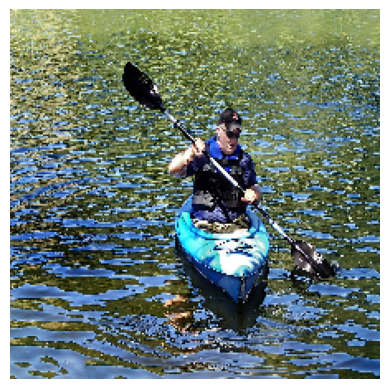

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predicted Class: kayak


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

def predict_and_show(img_path, model, class_names):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = np.expand_dims(image.img_to_array(img) / 255.0, axis=0)

    plt.imshow(img); plt.axis("off"); plt.show()
    print(f"Predicted Class: {class_names[np.argmax(model.predict(img_array)[0])]}")

# Load an image for prediction
img_path = target_path+"/kayak/11.jpg"  # Change this to your test image path
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.0  # Normalize

# Make prediction
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions[0])  # Get class index
#class_names = train_ds.class_names  # Get class labels

predict_and_show(img_path, model, class_names)


In [ ]:
# Save the model
## Already saved ##  model.save('/content/gdrive/MyDrive/Colab_Notebooks/IIT-Kanpur/04_Deep_Learning_With_Keras_TF/mobilenetv2_model.h5')
# Command to load the model
model = keras.models.load_model('/content/gdrive/MyDrive/Colab_Notebooks/IIT-Kanpur/04_Deep_Learning_With_Keras_TF/mobilenetv2_model.h5')


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8492 - loss: 0.8133
Test Accuracy: 0.8578
Test Loss: 0.9425


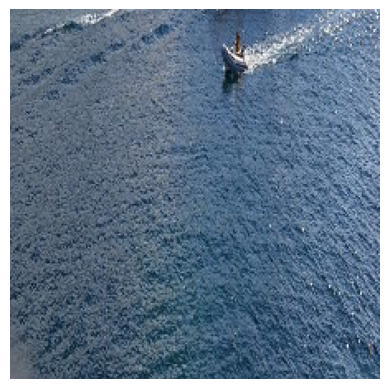

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Predicted: inflatable_boat


In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Loss: {loss:.4f}")

# Function to display image and predict class
def predict_and_show(img_path, model, class_names):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = np.expand_dims(image.img_to_array(img) / 255.0, axis=0)

    plt.imshow(img); plt.axis("off"); plt.show()
    print(f"Predicted: {class_names[np.argmax(model.predict(img_array)[0])]}")

# Example usage
predict_and_show(target_path+"/inflatable_boat/13.jpg", model, class_namesclass_name)